# 数据挖掘-预测贷款用户是否逾期
## Task5：模型调优（2天）

------
### 1&emsp;划分数据集

 - 导入宏包

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['font.sans-serif']=[u'SimHei']
mpl.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.float_format',lambda x : '%.5f' % x)

 - 导入数据

In [2]:
data = pd.read_csv('./data/data_clean.csv', encoding='gbk')
Y = data['status']
X = data.drop(['status'], axis=1)

 - 归一化

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

 - 划分数据集

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)

 - SMOTE 上采样

In [5]:
from imblearn.over_sampling import SMOTE
x_train_smote, y_train_smote = SMOTE(random_state=2018).fit_sample(x_train, y_train)

Using TensorFlow backend.


------
### 2&emsp;模型调优

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

 - 生成评价函数

In [7]:
def Eva(d,ls):
    t = np.sum(d[:,3])
    f = d.shape[0] - t

    TP = 1
    TN = f
    FP = 0
    FN = t-1

    TPR = [1/t]
    FPR = [0]
    AUC = 0
    
    P = [1]
    R = [1 / t]
    l = [1 - 1 / t]
    
    m = 1

    for i in range(1, d.shape[0]):
        if d[i,3] == 1:
            TP = TP+1
            FN = FN-1

        if d[i,3] == 0:
            FP = FP+1
            TN = TN-1

        TPR.append(TP/(TP+FN))
        FPR.append(FP/(TN+FP))
        AUC = AUC+0.5*((FPR[i]-FPR[i-1])*(TPR[i]+TPR[i-1]))
        
        P.append(TP / (TP + FP))
        R.append(TP / (TP + FN))
        l.append(np.abs(P[i] - R[i]))
        
        if ((TP+TN)/d.shape[0] == ls) & (m == 1):
            m = 0
            print("AC = {:.3f}".format(ls))
            print("P = {:.3f}".format(P[-1]))
            print("R = {:.3f}".format(R[-1]))
            
    
    x = np.linspace(0, 1)
    y = np.linspace(0, 1)
    
    plt.figure()
    plt.plot(R, P)
    plt.plot(x, y)  
    l_min = l.index(min(l))
    plt.plot(P[l_min], R[l_min], 'ro')
    plt.title('P-R 曲线')
    
    plt.figure()
    plt.plot(FPR,TPR)
    plt.plot(x, y, '--')
    plt.title('ROC 曲线')
    
    print("F1 = {:.3f}".format(2 * P[l_min] * R[l_min] / (P[l_min] + R[l_min])))
    print("AUC = {:.3f}".format(AUC))

#### 2.1 支持向量机

 - 重要超参数：
    
1. 核函数 ```kernel```

2. 硬间隔与软间隔 ```C```：```C```默认为1，必须大于等于0

3. 高斯核宽度 ```gamma```：若核函数 ```kernel = 'linear'``` 则不用此参数

 - 网格搜索

In [8]:
from sklearn.svm import SVC
parameters = {'gamma':[0.001, 0.01, 0.1, 1, 10, 100],
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}
GS = GridSearchCV(SVC(probability=True), parameters, cv=5, scoring='roc_auc')
GS.fit(x_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

 - 查看结果

In [9]:
result = pd.DataFrame(GS.cv_results_)
result.head(6).T

,0,1,2,3,4,5
mean_fit_time,10.15722,9.53608,9.77644,9.68987,9.45689,9.05736
std_fit_time,0.90364,0.92239,0.70429,0.80503,0.90765,0.40448
mean_score_time,0.46895,0.33193,0.46118,0.32034,0.27428,0.46796
std_score_time,0.16873,0.13723,0.16253,0.11261,0.02295,0.16709
param_C,0.00100,0.00100,0.00100,0.00100,0.00100,0.00100
param_gamma,0.00100,0.01000,0.10000,1,10,100
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}","{'C': 0.001, 'gamma': 100}"
split0_test_score,0.72779,0.72774,0.72740,0.71109,0.89608,0.94328
split1_test_score,0.71499,0.71508,0.71658,0.70904,0.90261,0.94548
split2_test_score,0.70831,0.70867,0.71145,0.71681,0.95706,0.99715


In [10]:
SVM=GS.best_estimator_
print('Test set score: {:.3f}'.format(GS.score(x_test,y_test)))
print('Best parameters: {}'.format(GS.best_params_))
print('Best cross-validation score: {:.3f}'.format(GS.best_score_))
print('Best estimator:\n{}'.format(GS.best_estimator_))

Test set score: 0.668
Best parameters: {'C': 10, 'gamma': 10}
Best cross-validation score: 0.979
Best estimator:
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


 - 热图可视化

D:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


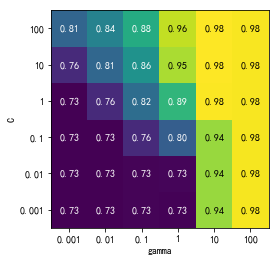

In [11]:
import mglearn
score = np.array(result.mean_test_score).reshape(6,6)
mglearn.tools.heatmap(score, xlabel = 'gamma', xticklabels = parameters['gamma'], 
                      ylabel = 'C', yticklabels = parameters['C'], cmap='viridis')

 - 模型评价

AC = 0.736
P = 0.429
R = 0.009
F1 = 0.415
AUC = 0.668


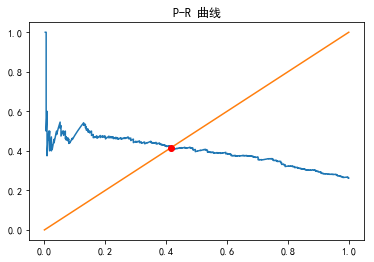

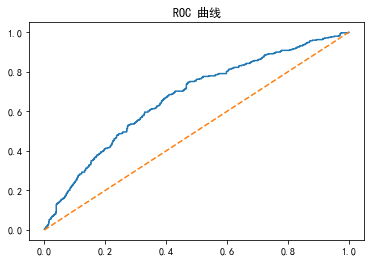

In [12]:
# test_set score
y_proba = SVM.predict_proba(x_test)
y_predi = SVM.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
Eva(d,SVM.score(x_test, y_test))

|得分|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|调参前|0.657|0.406|0.653|0.493|0.733|
|调参后|0.736|0.429|0.009|0.427|0.668|

#### 2.2 逻辑回归

 - 重要超参数：
    
1. ```penalty```: ```l1``` 和 ```l2``` ，默认 ```l2``` 。若选择 ```l1``` 正则化，参数 ```solver``` 仅能够使用求解方式 ```liblinear``` 和 ```saga``` ；若使用 ```l2``` 正则化，参数 ```solver``` 中所有的求解方式都可以使用。
2. ```C```：正则化强度的倒数，默认为1。```C``` 越小，损失函数越小，惩罚函数越大，在一定程度上减少过拟合的发生。

 - 网格搜索

In [13]:
from sklearn.linear_model import LogisticRegression
parameters = {'penalty':['l1','l2'],
             'C':np.linspace(0.05,1,20).tolist()}
GS = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring='roc_auc')
GS.fit(x_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,
                               0.39999999999999997, 0.44999999999999996,
                               0.49999999999999994, 0.5499999999999999, 0.6,
                               0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9,
                               0.95, 1.0],
 

 - 查看结果

In [14]:
result = pd.DataFrame(GS.cv_results_)
result.head(6).T

,0,1,2,3,4,5
mean_fit_time,0.04029,0.03611,0.05785,0.03771,0.06084,0.02175
std_fit_time,0.00360,0.00147,0.00303,0.00040,0.01481,0.00116
mean_score_time,0.00241,0.00219,0.00220,0.00199,0.00239,0.00099
std_score_time,0.00049,0.00040,0.00040,0.00002,0.00050,0.00002
param_C,0.05000,0.05000,0.10000,0.10000,0.15000,0.15000
param_penalty,l1,l2,l1,l2,l1,l2
params,"{'C': 0.05, 'penalty': 'l1'}","{'C': 0.05, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 0.15, 'penalty': 'l1'}","{'C': 0.15, 'penalty': 'l2'}"
split0_test_score,0.77281,0.76839,0.79583,0.78093,0.80387,0.78820
split1_test_score,0.76742,0.76212,0.79755,0.77701,0.80676,0.78594
split2_test_score,0.76138,0.74948,0.79752,0.76435,0.80716,0.77388


In [15]:
LR=GS.best_estimator_
print('Test set score: {:.3f}'.format(GS.score(x_test,y_test)))
print('Best parameters: {}'.format(GS.best_params_))
print('Best cross-validation score: {:.3f}'.format(GS.best_score_))
print('Best estimator:\n{}'.format(GS.best_estimator_))

Test set score: 0.773
Best parameters: {'C': 1.0, 'penalty': 'l1'}
Best cross-validation score: 0.832
Best estimator:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


 - 热图可视化

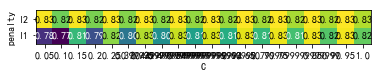

In [16]:
import mglearn
score = np.array(result.mean_test_score).reshape(2,20)
mglearn.tools.heatmap(score, ylabel = 'penalty', yticklabels = parameters['penalty'], 
                      xlabel = 'C', xticklabels = parameters['C'], cmap='viridis')

 - 模型评价

AC = 0.732
P = 0.492
R = 0.607
F1 = 0.533
AUC = 0.773


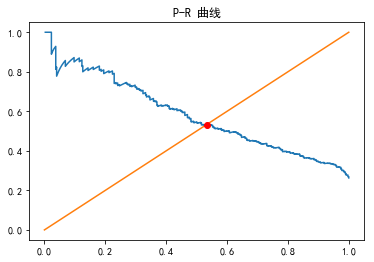

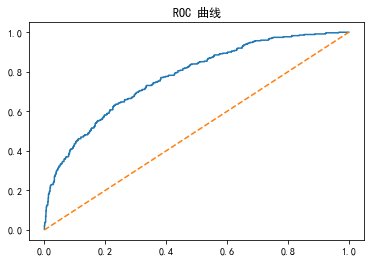

In [17]:
# test_set score
y_proba = LR.predict_proba(x_test)
y_predi = LR.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
Eva(d,LR.score(x_test, y_test))

|得分|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|调参前|0.721|0.477|0.616|0.539|0.767|
|调参后|0.732|0.492|0.607|0.533|0.773|

#### 2.3 决策树

 - 重要超参数：
 
   分类树的8个重要参数：```criterion```、2个随机性相关的参数 (```random_state```、```splitter```）、5个剪枝参数（```max_depth```、```min_samples_split```、```min_samples_leaf```、```max_feature```、```min_impurity_decrease```）。
   
1. ```criterion```：不纯度计算方法。信息熵 ```entropy``` 和基尼系数 ```gini``` ，默认 ```gini```。

2. ```random_state```：设置分枝中随机模式的参数。默认为 ```None```。

3. ```splitter```：控制决策树中的随机选项。```best``` 和```random``` ，默认最佳分枝 ```best```（分枝虽随机，但会优先选择更重要的特征分枝）。

4. ```max_depth```：树大最大深度。建议从3开始尝试。

5. ```min_samples_split```：一个节点至少包含 ```min_samples_split``` 个训练样本。默认为2。

6. ```min_samples_leaf```：一个节点在分枝后的每个子节点都必须包含 ```min_samples_leaf``` 个训练样本。建议从5开始尝试。

7. ```max_features```：限制分枝时考虑的特征个数（和 ```max_depth``` 异曲同工）。

 - 网格搜索

In [18]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'splitter':('best','random'),
              'criterion':('gini','entropy'),
              'max_depth':[*range(1,10)],
              'min_samples_leaf':[*range(1,50,5)],
              'min_impurity_decrease':[*np.linspace(0,0.5,20)],
              }
GS = GridSearchCV(DecisionTreeClassifier(random_state=2018), parameters, cv=5, scoring='roc_auc')
GS.fit(x_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=2018,
                                              splitter='best'),
             iid='warn', n...
                                                   0.23684210526315788,
                                                   0.2631578947368421,
 

 - 查看结果

In [19]:
result = pd.DataFrame(GS.cv_results_)
result.head(6).T

,0,1,2,3,4,5
mean_fit_time,0.03272,0.00319,0.01439,0.00340,0.01477,0.00359
std_fit_time,0.00385,0.00040,0.00047,0.00049,0.00076,0.00046
mean_score_time,0.00181,0.00099,0.00078,0.00060,0.00059,0.00061
std_score_time,0.00039,0.00002,0.00039,0.00049,0.00048,0.00049
param_criterion,gini,gini,gini,gini,gini,gini
param_max_depth,1,1,1,1,1,1
param_min_impurity_decrease,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
param_min_samples_leaf,1,1,6,6,11,11
param_splitter,best,random,best,random,best,random
params,"{'criterion': 'gini', 'max_depth': 1, 'min_imp...","{'criterion': 'gini', 'max_depth': 1, 'min_imp...","{'criterion': 'gini', 'max_depth': 1, 'min_imp...","{'criterion': 'gini', 'max_depth': 1, 'min_imp...","{'criterion': 'gini', 'max_depth': 1, 'min_imp...","{'criterion': 'gini', 'max_depth': 1, 'min_imp..."


In [20]:
DTC=GS.best_estimator_
print('Test set score: {:.3f}'.format(GS.score(x_test,y_test)))
print('Best parameters: {}'.format(GS.best_params_))
print('Best cross-validation score: {:.3f}'.format(GS.best_score_))
print('Best estimator:\n{}'.format(GS.best_estimator_))

Test set score: 0.713
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 11, 'splitter': 'best'}
Best cross-validation score: 0.866
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2018, splitter='best')


 - 模型评价

AC = 0.717
P = 0.460
R = 0.433
F1 = 0.461
AUC = 0.712


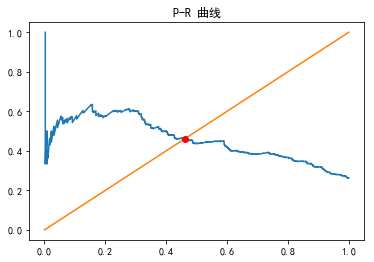

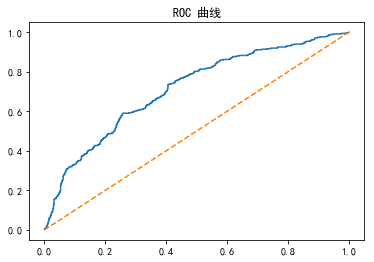

In [21]:
# test_set score
y_proba = DTC.predict_proba(x_test)
y_predi = DTC.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
Eva(d, DTC.score(x_test, y_test))

|得分|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|调参前|0.699|0.431|0.450|0.438|0.767|
|调参后|0.717|0.460|0.433|0.461|0.712|

#### 2.4 随机森林

 - 重要超参数
 
1. 控制基评估器的参数：```criterion```、```max_depth```、```min_samples_split```、```min_samples_leaf```、```max_feature```、```min_impurity_decrease```。

2. ```n_estimators```:森林中树木的数量，即基评估器的数量。```n_estimators```越大，模型的效果越好。```n_estimators```的默认值在现有版本的sklearn中是10，但是在即将更新的0.22版本中，这个默认值会被修正为100。一般来说，0-200选一个数会比较好。

3. ```random_state```:控制生成森林的模式。而在分类树最后，一个```random_state```只控制生成一棵树。

4. ```bootstrap```：控制抽样技术的参数，默认为```True```，代表有放回的抽样技术。

 - 随机搜索

In [22]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_depth': [3, 4, 5, 6, 7],
              'max_features': sp_randint(1, 11),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']
              }
n_iter_search = 20
RS = RandomizedSearchCV(RandomForestClassifier(random_state=2018), parameters,
                                   n_iter=n_iter_search, cv=5, iid=False, scoring='roc_auc')
RS.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

 - 查看结果

In [23]:
result = pd.DataFrame(RS.cv_results_)
result.head(6).T

,0,1,2,3,4,5
mean_fit_time,0.15957,0.15838,0.09176,0.03951,0.05186,0.04348
std_fit_time,0.00615,0.00580,0.03934,0.00204,0.00328,0.00136
mean_score_time,0.00539,0.00539,0.00260,0.00240,0.00198,0.00240
std_score_time,0.00048,0.00048,0.00120,0.00049,0.00002,0.00047
param_bootstrap,False,False,True,False,False,False
param_criterion,gini,gini,gini,entropy,gini,gini
param_max_depth,7,7,6,6,3,4
param_max_features,5,5,8,2,8,5
param_min_samples_split,2,2,8,10,4,4
params,"{'bootstrap': False, 'criterion': 'gini', 'max...","{'bootstrap': False, 'criterion': 'gini', 'max...","{'bootstrap': True, 'criterion': 'gini', 'max_...","{'bootstrap': False, 'criterion': 'entropy', '...","{'bootstrap': False, 'criterion': 'gini', 'max...","{'bootstrap': False, 'criterion': 'gini', 'max..."


In [24]:
RFC=RS.best_estimator_
print('Test set score: {:.3f}'.format(RS.score(x_test,y_test)))
print('Best parameters: {}'.format(RS.best_params_))
print('Best cross-validation score: {:.3f}'.format(RS.best_score_))
print('Best estimator:\n{}'.format(RS.best_estimator_))

Test set score: 0.766
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 9, 'min_samples_split': 3}
Best cross-validation score: 0.900
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)


 - 模型评价

AC = 0.747
P = 1.000
R = 0.037
F1 = 0.510
AUC = 0.766


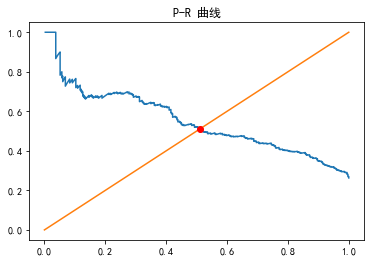

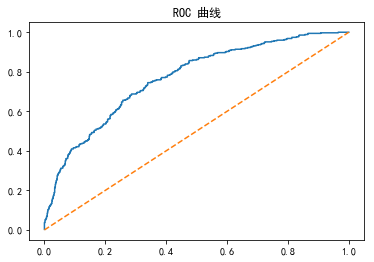

In [25]:
# test_set score
y_proba = RFC.predict_proba(x_test)
y_predi = RFC.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
Eva(d, RFC.score(x_test, y_test))

|得分|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|调参前|0.751|0.725|0.083|0.499|0.724|
|调参后|0.747|1.000|0.037|0.510|0.766|

#### 2.5 XGBoost

 - 重要超参数
 
1. ```max_depth```: 每棵树的最大深度。太小会欠拟合，太大过拟合。正常值是3到10。

2. ```learning_rate```: 学习率，也就是梯度下降法中的步长。太小的话，训练速度太慢，而且容易陷入局部最优点。通常是0.0001到0.1之间。

3. ```n_estimators```: 树的个数。并非越多越好，通常是50到1000之间。

4. ```colsample_bytree```: 训练每个树时用的特征的数量。1表示使用全部特征，0.5表示使用一半的特征。

5. ```subsample```: 训练每个树时用的样本的数量。与上述类似，1表示使用全部样本，0.5表示使用一半的样本。

6. ```reg_alpha```: L1正则化的权重。用来防止过拟合。一般是0到1之间。

7. ```reg_lambda```: L2正则化的权重。用来防止过拟合。一般是0到1之间。

8. ```min_child_weight```: 每个子节点所需要的样本的数量（加权的数量）。若把它设置为大于1的数值，可以起到剪枝的效果，防止过拟合。

 - 随机搜索

In [26]:
from xgboost import XGBClassifier
parameters = {'max_depth': [3, 4, 5, 6, 7, 8],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'learning_rate': [0.01, 0.1, 0.2],
              'min_child_weight': [1, 2, 3],
              }
n_iter_search = 20
RS = RandomizedSearchCV(XGBClassifier(random_state=2018), parameters,
                                   n_iter=n_iter_search, cv=5, iid=False, scoring='roc_auc')
RS.fit(x_train_smote, y_train_smote)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=2018, reg_alph...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=False, n_iter=20, n_jobs=None,
                   param_distri

 - 查看结果

In [27]:
result = pd.DataFrame(RS.cv_results_)
result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,3.04338,2.77238,4.14032,3.81680,1.93363,3.63647,3.54731,3.88521,4.27736,3.17791,5.78353,3.01872,2.60683,2.03116,4.83327,2.58071,3.78487,1.53310,5.60959,2.69500
std_fit_time,0.75623,0.67637,0.11454,0.70491,0.49887,0.82747,0.79327,0.76141,0.54175,0.64415,0.67485,0.08222,0.23533,0.61745,1.01394,0.34231,0.65116,0.39869,0.89751,0.62820
mean_score_time,0.01457,0.01037,0.01277,0.01315,0.00898,0.01835,0.01555,0.01236,0.01895,0.01675,0.01676,0.01217,0.01017,0.00878,0.01915,0.01276,0.01636,0.00898,0.01775,0.01157
std_score_time,0.00605,0.00319,0.00074,0.00314,0.00245,0.00421,0.00499,0.00275,0.00001,0.00391,0.00391,0.00040,0.00264,0.00270,0.00040,0.00344,0.00049,0.00244,0.00439,0.00279
param_subsample,0.50000,0.70000,1.00000,1.00000,0.60000,0.70000,0.50000,0.70000,0.90000,0.70000,0.80000,1.00000,1.00000,0.50000,0.60000,0.90000,0.70000,1.00000,0.90000,0.50000
param_min_child_weight,1,2,1,2,2,3,1,3,1,3,2,1,2,2,1,3,1,1,1,1
param_max_depth,8,4,5,5,3,8,8,5,7,7,7,4,4,3,7,5,6,3,8,4
param_learning_rate,0.01000,0.20000,0.01000,0.20000,0.10000,0.01000,0.20000,0.01000,0.10000,0.01000,0.01000,0.20000,0.01000,0.20000,0.20000,0.01000,0.01000,0.10000,0.20000,0.20000
param_colsample_bytree,0.50000,0.90000,0.90000,1.00000,0.80000,0.50000,0.60000,1.00000,0.70000,0.50000,1.00000,0.80000,0.70000,0.90000,0.90000,0.50000,0.70000,0.60000,0.90000,0.90000
params,"{'subsample': 0.5, 'min_child_weight': 1, 'max...","{'subsample': 0.7, 'min_child_weight': 2, 'max...","{'subsample': 1.0, 'min_child_weight': 1, 'max...","{'subsample': 1.0, 'min_child_weight': 2, 'max...","{'subsample': 0.6, 'min_child_weight': 2, 'max...","{'subsample': 0.7, 'min_child_weight': 3, 'max...","{'subsample': 0.5, 'min_child_weight': 1, 'max...","{'subsample': 0.7, 'min_child_weight': 3, 'max...","{'subsample': 0.9, 'min_child_weight': 1, 'max...","{'subsample': 0.7, 'min_child_weight': 3, 'max...","{'subsample': 0.8, 'min_child_weight': 2, 'max...","{'subsample': 1.0, 'min_child_weight': 1, 'max...","{'subsample': 1.0, 'min_child_weight': 2, 'max...","{'subsample': 0.5, 'min_child_weight': 2, 'max...","{'subsample': 0.6, 'min_child_weight': 1, 'max...","{'subsample': 0.9, 'min_child_weight': 3, 'max...","{'subsample': 0.7, 'min_child_weight': 1, 'max...","{'subsample': 1.0, 'min_child_weight': 1, 'max...","{'subsample': 0.9, 'min_child_weight': 1, 'max...","{'subsample': 0.5, 'min_child_weight': 1, 'max..."


In [28]:
XGB=RS.best_estimator_
print('Test set score: {:.3f}'.format(RS.score(x_test,y_test)))
print('Best parameters: {}'.format(RS.best_params_))
print('Best cross-validation score: {:.3f}'.format(RS.best_score_))
print('Best estimator:\n{}'.format(RS.best_estimator_))

Test set score: 0.784
Best parameters: {'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best cross-validation score: 0.944
Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2018,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


 - 模型评价

AC = 0.784
P = 0.670
R = 0.355
F1 = 0.527
AUC = 0.784


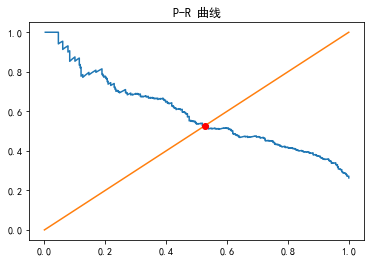

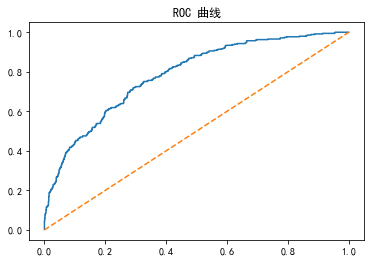

In [29]:
# test_set score
y_proba = XGB.predict_proba(x_test)
y_predi = XGB.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
Eva(d, XGB.score(x_test, y_test))

|得分|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|调参前|0.769|0.765|0.178|0.536|0.788|
|调参后|0.784|0.670|0.355|0.527|0.784|

### 3&emsp;模型比较

|模型|AC|P|R|F1|AUC|
|:-:|:-:|:-:|:-:|:-:|:-:|
|Support Vector Classifier|0.736|0.429|0.009|0.427|0.668|
|Logistic Regression|0.732|0.492|0.607|0.533|0.773|
|Decision Trees Classifier|0.717|0.460|0.433|0.461|0.712|
|Random Forest Classifier|0.747|1.000|0.037|0.510|0.766|
|eXtreme Gradient Boosting Classifier|0.784|0.670|0.355|0.527|0.784|